In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
#!mkdir GloVe
#!curl -Lo GloVe/glove.840B.300d.zip http://nlp.stanford.edu/data/glove.840B.300d.zip
#!unzip GloVe/glove.840B.300d.zip -d GloVe/
!mkdir fastText
!curl -Lo fastText/crawl-300d-2M.vec.zip https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
!unzip fastText/crawl-300d-2M.vec.zip -d fastText/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1453M  100 1453M    0     0  6545k      0  0:03:47  0:03:47 --:--:-- 8028k 4900k1kk:01:29  585k0:01:02 8104k97k      0  0:03:52  0:03:30  0:00:22 8624k 0:03:52  0:03:32  0:00:20 8282k  0:03:47  0:03:47 --:--:-- 8057k
Archive:  fastText/crawl-300d-2M.vec.zip
  inflating: fastText/crawl-300d-2M.vec  


In [3]:
!mkdir encoder
!curl -Lo encoder/infersent1.pkl https://dl.fbaipublicfiles.com/infersent/infersent1.pkl
!curl -Lo encoder/infersent2.pkl https://dl.fbaipublicfiles.com/infersent/infersent2.pkl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  146M  100  146M    0     0  7134k      0  0:00:21  0:00:21 --:--:-- 8323k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  146M  100  146M    0     0  6537k      0  0:00:23  0:00:23 --:--:-- 8134k-:--     0k00:23  0:00:16  0:00:07 8911k


In [4]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ravitiwari/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
!pip install torchvision 

In [5]:
import torch

In [7]:
from models import InferSent
V = 2
MODEL_PATH = 'encoder/infersent%s.pkl' % V
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': V}
infersent = InferSent(params_model)
infersent.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [8]:
W2V_PATH = 'fastText/crawl-300d-2M.vec'
infersent.set_w2v_path(W2V_PATH)

In [9]:
data=pd.read_csv("NEW_DATASET_PREPROCESSED.csv")
data

Unnamed: 0                                              tweet  label
0               0  a a woman you should not complain about cleani...      2
1               1  boy dat cold tyga dwn bad for cuffin dat hoe i...      1
2               2  dawg you ever fuck a bitch and she sta to cry ...      1
3               3                             she look like a tranny      1
4               4  the shit you hear about me might be true or it...      1
...           ...                                                ...    ...
71994       71994  whose twitter interest sta with food is he eve...      2
71995       71995                   how did the press get the letter      2
71996       71996  sorry about your son i am sure he would not wa...      2
71997       71997                                 fuck alan im sorry      1
71998       71998  conservative sajidjavid productive discussion ...      2

[71999 rows x 3 columns]

In [10]:
data.drop("Unnamed: 0",axis=1,inplace=True)
data

tweet  label
0      a a woman you should not complain about cleani...      2
1      boy dat cold tyga dwn bad for cuffin dat hoe i...      1
2      dawg you ever fuck a bitch and she sta to cry ...      1
3                                 she look like a tranny      1
4      the shit you hear about me might be true or it...      1
...                                                  ...    ...
71994  whose twitter interest sta with food is he eve...      2
71995                   how did the press get the letter      2
71996  sorry about your son i am sure he would not wa...      2
71997                                 fuck alan im sorry      1
71998  conservative sajidjavid productive discussion ...      2

[71999 rows x 2 columns]

In [11]:
data.dropna(inplace=True)
data.shape

(71804, 2)

In [12]:
data.label.value_counts()

1    31392
2    31105
0     7193
3     2114
Name: label, dtype: int64

In [13]:
y=data['label']
x=data['tweet']

## Spliting the Dataset

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y)


print(X_train.shape, y_train.shape)

print(X_test.shape, y_test.shape)


(53853,) (53853,)
(17951,) (17951,)


## Building Vocab of 100000 words

In [15]:
infersent.build_vocab_k_words(K=100000)

Vocab size : 100000


In [16]:
%%time
X_train_tweet = infersent.encode(X_train, tokenize=True)
print("X_Train Done")
print("="*180)

X_test_tweet = infersent.encode(X_test, tokenize=True)

print("After Embedding vectorizations")
print(X_train_tweet.shape, y_train.shape)

print(X_test_tweet.shape, y_test.shape)
print("="*100)

/Users/ravitiwari/Desktop/NEW_Project/MODELS/models.py:207: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sentences = np.array(sentences)[idx_sort]


X_Train Done
After Embedding vectorizations
(53853, 4096) (53853,)
(17951, 4096) (17951,)
CPU times: user 47min 42s, sys: 21.3 s, total: 48min 3s
Wall time: 45min 49s


In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

In [ ]:
def train_test_model(model, X_train, X_test, y_train, y_test,labels):
    print('Start training...', end='')
    model.fit(X_train, y_train)
    print('done!')
    print("="*80)
    print('Start testing...', end='')
    predictions = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    metrics_report = classification_report(y_test, predictions, target_names=labels)
    precision, recall, fscore, train_support = score(y_test, predictions, average='weighted')
    print('done!')
    print("="*80)
    return predictions, accuracy, metrics_report, (precision, recall, fscore)

In [ ]:
labels_=['hatefull','offensive','neither','Tobacco']

# With Class_Weights

In [18]:
weights={0:0.259068,1:0.079680,2:0.154860,3:1}

In [17]:
data.label.value_counts()

1    26531
2    13651
0     8160
3     2114
Name: label, dtype: int64

Start training...done!
Start testing...done!
accuracy: 0.739971460282226
              precision    recall  f1-score   support

    hatefull       0.53      0.68      0.60      2040
   offensive       0.89      0.68      0.77      6633
     neither       0.67      0.86      0.75      3413
     Tobacco       0.91      0.96      0.93       528

    accuracy                           0.74     12614
   macro avg       0.75      0.79      0.76     12614
weighted avg       0.77      0.74      0.74     12614



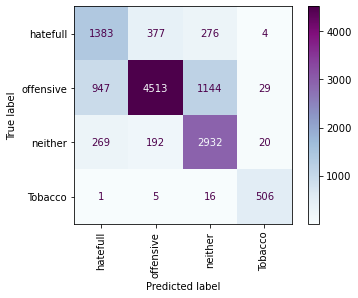

In [19]:
log_model=LogisticRegression(penalty='l2',max_iter=1000,class_weight=weights)
predictions, accuracy, metrics_report, log_prf = train_test_model(log_model, X_train_tweet, X_test_tweet, y_train, y_test, labels_)


print('accuracy: {}'.format(accuracy))
print('='*100)
print(metrics_report)

plot_confusion_matrix(log_model, X_test_tweet, y_test, display_labels=labels_, xticks_rotation='vertical', cmap="BuPu")

Start training...done!
Start testing...done!
accuracy: 0.7555890280640558
              precision    recall  f1-score   support

    hatefull       0.59      0.61      0.60      2040
   offensive       0.86      0.74      0.80      6633
     neither       0.68      0.83      0.75      3413
     Tobacco       0.87      0.96      0.92       528

    accuracy                           0.76     12614
   macro avg       0.75      0.79      0.77     12614
weighted avg       0.77      0.76      0.76     12614



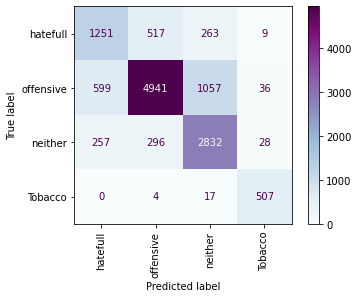

In [20]:
svm = LinearSVC(class_weight=weights, verbose=False, max_iter=10000, tol=1e-4, C=0.1)

predictions, accuracy, metrics_report, svm_prf = train_test_model(svm, X_train_tweet, X_test_tweet, y_train, y_test, labels_)


print('accuracy: {}'.format(accuracy))
print('='*100)
print(metrics_report)

plot_confusion_matrix(svm, X_test_tweet, y_test, display_labels=labels_, xticks_rotation='vertical', cmap="BuPu")